In [1]:
%reload_ext autoreload
%autoreload 2
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import realsense_photo as rsp
import CustomDataset as cdset
import pickle
import network_shell as nsh
import os
from IPython.display import display, clear_output
from tqdm import *


from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Import success, loaded device = ", device)

Import success, loaded device =  cuda:0


In [2]:
#loading architexture
import segmentation_models_pytorch as smp
learning_rate = 0.0005

#creating new model
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=9,                      # model output channels (number of classes in your dataset)
)
#or loading already trained model
#model = torch.load("model")

criterion = smp.losses.JaccardLoss('multiclass', classes=None, log_loss=False, from_logits=True, smooth=0.0, eps=1e-07)
#criterion = nn.NLLLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

print("Model load success")

Model load success


In [3]:
#loading some series of photos
train_loader, val_loader = nsh.makeLoaders(["data/home", "data/old_corpus", "data/new_corpus", "data/big_pack4"], batch_size = 10)
print("Train loader success, number of batchs: ", len(train_loader))
print("Val loader success, number of batchs: ", len(val_loader))

Train loader success, number of batchs:  10
Val loader success, number of batchs:  3


Gym training status:
Epoch [1/40]
Current values: loss: 0.0000, train_acc: 0.0000, val_acc: 0.0000


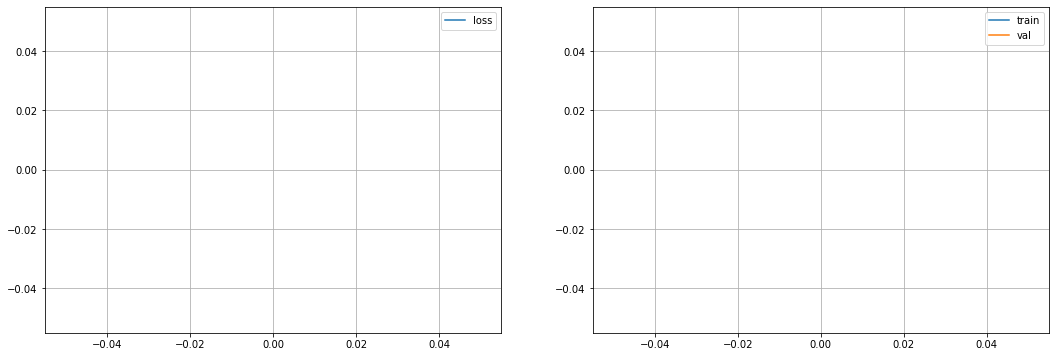

Train progress:  10%|██████▋                                                            | 1/10 [00:12<01:55, 12.87s/it]

In [ ]:
#gym training
num_epochs = 40

total_step = len(train_loader)
loss_list = []
train_acc_list = []
val_acc_list = []
model = model.float()
#model.to(device)

ave_loss = 0
ave_train_acc = 0
ave_val_acc = 0

for epoch in range(num_epochs):
    clear_output(wait=True)
    print("Gym training status:")
    print("Epoch [{}/{}]".format(epoch+1,num_epochs))
    print("Current values: loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(ave_loss, ave_train_acc, ave_val_acc), flush=True)
    nsh.resPlotter(loss_list, train_acc_list, val_acc_list)
    
    loss_accum = 0
    train_acc_accum = 0
    val_acc_accum = 0

    train_bar = tqdm(total=len(train_loader), position = 0, leave = False, desc='Train progress')
    for i, (images, labels, _) in enumerate(train_loader):
        train_bar.update(1)
        
        # Прямой запуск
        #images = images.to(device)
        #labels = labels.to(device)
        
        model.train()
        outputs = model(images.float())
        loss = criterion(outputs, labels.long())
        loss_accum += loss

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        picture = nsh.preds_to_images(outputs)
        picture = picture.reshape((picture.shape[0],1,picture.shape[1], picture.shape[2]))
        
        total = labels.size(0)*labels.size(2)*labels.size(3)
        correct = (picture == labels).sum().item()
        
        train_acc_accum += correct / total
        
        ave_loss = loss_accum / (i+1)
        ave_train_acc = train_acc_accum / (i+1)
        
        #print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, train acc: {:.4f}'
        #      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), correct / total))
    train_bar.close()
    
    
    loss_list.append(ave_loss.detach().numpy())
    train_acc_list.append(ave_train_acc)
    
    
    if scheduler is not None:
            scheduler.step(ave_loss)
            
    val_bar = tqdm(total=len(val_loader), position = 0, leave = False, desc='Val progress')        
    for i, (images, labels,_) in enumerate(val_loader):
        val_bar.update(1)
        
        outputs = model(images.float())
        model.eval()
        
        picture = nsh.preds_to_images(outputs)
        picture = picture.reshape((picture.shape[0],1,picture.shape[1], picture.shape[2]))
        
        total = labels.size(0)*labels.size(2)*labels.size(3)
        correct = (picture == labels).sum().item()
        val_acc_accum += correct / total
        ave_val_acc = val_acc_accum / (i+1)
        
        #print('Epoch [{}/{}], Step [{}/{}], val acc: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, correct / total))
    val_bar.close()
    val_acc_list.append(ave_val_acc)

In [6]:
#model.to(torch.device("cpu"))
for i, (images, labels, _) in enumerate(val_loader):
        print("loading ", i, " photo")
        #print(images.shape)
        outputs = model(images.float())
        loss = criterion(outputs, labels.long())
        picture = nsh.preds_to_images(outputs)
        total = labels.size(0)*labels.size(2)*labels.size(3)
        correct = (picture == labels[:,0,:,:]).sum().item()

        print('Val Loss: {:.4f}, acc {:.4f}'
                  .format(loss.item(), correct/total))
        
        
        
        rgb_to_draw = np.transpose(images[:,0:3,:,:], (0,2,3,1))
        label_pred_to_draw = np.transpose(picture[:,:,:], (0,1,2))
        label_to_draw = np.transpose(labels[:,:,:,:], (1,0,2,3))
        label_to_draw = label_to_draw[0]
        
        rsp.drawLabelMap(rgb_to_draw.numpy(), label_to_draw.numpy(), label_pred_to_draw.numpy())
    

loading  0  photo
Val Loss: 0.2838, acc 0.9508
loading  1  photo
Val Loss: 0.3403, acc 0.9215


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "saves/"+str(ave_val_acc))
print("Model saved with values: loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(ave_loss, ave_train_acc, ave_val_acc), flush=True)

In [5]:
model.load_state_dict(torch.load("saves/0.8668207465277779"))

<All keys matched successfully>

In [4]:
#loading some series of photos
train_loader, val_loader = nsh.makeLoaders(["data/test"], 
                                           validation_fraction = 1, batch_size = 10)
print("Train loader success, number of batchs: ", len(train_loader))
print("Val loader success, number of batchs: ", len(val_loader))

Train loader success, number of batchs:  0
Val loader success, number of batchs:  4
